In [6]:
import os
import seaborn as sns
path = '/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Analysis/Figures'
import sys
sys.path.insert(1, '/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Data Collection')
from configs import *
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.axislines import SubplotZero
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "lualatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

from sqlalchemy import create_engine

engine = create_engine('mysql+mysqlconnector://'+user+':'+passwd+'@'+ip+':3306/'+schema1)


In [ ]:
matplotlib.rcParams["text.usetex"] = True
plt.rcParams["figure.figsize"] = [8, 4]
plt.xlabel('Time', size = 12)
plt.ylabel('Expectations', size = 12)
plt.rcParams['figure.dpi'] = 300
ax = plt.gca()

In [3]:
stmt = 'SELECT DISTINCT(M.id), M.date, B.sentiment AS s FROM machine_learning M LEFT JOIN base_sentiment B ON M.id = B.id'
df = pd.read_sql(stmt, con=engine)

In [4]:
from datetime import datetime
def sentiment(sentiment):
    if sentiment == 0:
        return 'negative'
    if sentiment == 1:
        return 'neutral'
    if sentiment == 2:
        return 'positive'

def dformat(d):
    return datetime.strptime(d, '%Y-%m-%d').strftime('%Y')
    
df['sentiment'] = df['s'].apply(sentiment)
df.date = df.date.apply(dformat)

In [ ]:
df.head()

,id,date,sentiment,text_sentiment
0,7252999240,2010,2,positive
1,7253868177,2010,2,positive
2,7255267239,2010,2,positive
3,7258952966,2010,2,positive
4,7263560352,2010,2,positive


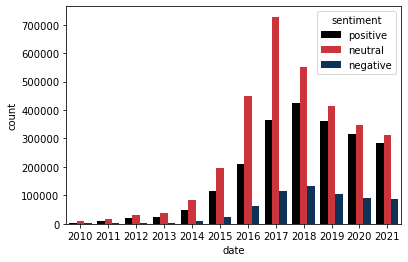

In [9]:
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Year')
plt.ylabel('Number of Tweets')
sns.countplot( x= "date", hue="sentiment", data=df, palette=['#d6e6f4',"#6aaed6", '#105ba4'])
plt.savefig(os.path.join(path, 'sentiment_count.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
plt.close()